### 0. 목적 
- 홍대/상권 분석의 가장 기본이 되는 데이터인 2010, 2020년 상권 정보에 대한 내용 확인용 코드

[1] 간단한 EDA를 통한 상권 변화 확인 
[2] 10년 동안 생존한 상권을 확인하기 위한 전처리
(해당 과정에서 명칭이 같은 상권을 추출하여 생존 상권으로 판단 


#### 1. 필요 모듈/데이터 불러오기

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 

pd.set_option('max_columns', 20, 'max_rows', 20)

%matplotlib inline

# 한글 폰트 설정
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

#### 데이터 불러오기

- F&B2010: 2010년 홍대/상수 지역에 존재한 상권 csv
- F&B2020: 2020년 홍대/상수 지역에 존재한 상권 csv
- 점포 수가 64% 증가

In [2]:
import pandas as pd 

data_2010 = pd.read_csv('F&B2010.csv', encoding = 'cp949')
data_2020 = pd.read_csv('F&B2020.csv', encoding = 'cp949')

data_2010_cnt = data_2010.shape[0]
data_2020_cnt = data_2020.shape[0]

print("2010년 홍대 상권 개수: {}개".format(data_2010_cnt))
print("2020년 홍대 상권 개수: {}개".format(data_2020_cnt))
print("(음식점/카페 분야) 점포수 증가율: {:.2f}%".format((data_2020_cnt - data_2010_cnt) / data_2010_cnt * 100))

2010년 홍대 상권 개수: 295개
2020년 홍대 상권 개수: 500개
(음식점/카페 분야) 점포수 증가율: 69.49%


### 2. 간단한 EDA

#### EDA (1): 홍대/상수 지역의 업종별 상권 개수 확인

- 2010년과 2020년 대비해서 업종 증가가 특정 업종에 집중되어 있음(한식, 패스트 푸드, 카페 등)

In [33]:
# 2010년도 개수 확인 
data_2010_cnt_type = pd.DataFrame(data_2010.UPJONG2_NM.value_counts()).reset_index()
data_2010_cnt_type.columns = ['업종','2010년_개수']

# 2020년 대비 10년도 다른 명칭 업종 변경
data_2010_cnt_type['업종'] = data_2010_cnt_type['업종'].agg(lambda x: "커피점/카페" if  x == "다방/커피숍/카페" else x)

# 2020년도 개수 확인 
data_2020_cnt_type = pd.DataFrame(data_2020.상권업종_2.value_counts()).reset_index()
data_2020_cnt_type.columns = ['업종','2020년_개수']

# 2010년, 2020년 업종별 개수 Data frame merge
feature_01 = pd.merge(data_2020_cnt_type, data_2010_cnt_type,  on = '업종', how = 'outer').fillna(0)
feature_01 = feature_01[['업종','2010년_개수','2020년_개수']]
feature_01['2010년_개수'] = feature_01['2010년_개수'].astype('int')
feature_01 = feature_01.set_index('업종').T
feature_01['합계'] = feature_01.sum(axis = 1)
feature_01 = feature_01.T


# 업종별 증가율 생성 list
value_list = []

# 2010년도에 없던 업종이 생성된 경우
for i in range(feature_01.shape[0]): 
    if feature_01.iloc[i, 0] == 0:
        value = "신규진입"
    else: 
        value = str(round((feature_01.iloc[i,1] - feature_01.iloc[i,0] ) /  feature_01.iloc[i,0]  * 100,0)) + '%'
    value_list.append(value)

# 업종별 증가율 
feature_01['업종별_증가율'] = value_list

feature_01 = feature_01.reset_index()
feature_01['세분화'] = feature_01['업종'].agg(lambda x: '기타' if x in ['기타음식업','음식배달서비스','부페'] else x)
feature_01 = feature_01.set_index('업종')

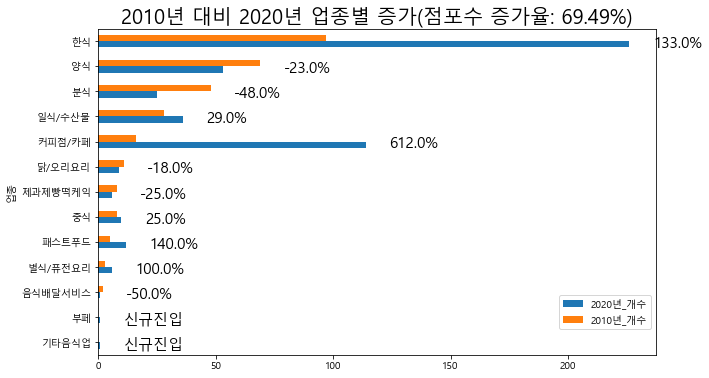

In [35]:
fig, ax = plt.subplots(figsize = (10,6))
a = feature_01.iloc[:-1,:-1].sort_values(by = '2010년_개수')[['2020년_개수','2010년_개수','업종별_증가율']]
a['EDA'] = a.max(axis = 1)

print()
a.iloc[:,:3].plot.barh(ax = ax)
ax.set_title('2010년 대비 2020년 업종별 증가(점포수 증가율: 69.49%)', fontsize = 20)

for pos in range(a.shape[0]):
        plt.text(a.iloc[pos, 3] + 10, pos - 0.25, s = a.iloc[pos, 2], fontsize = 15)

plt.legend(bbox_to_anchor = (1.0,0.2))
plt.show()

#### EDA (2): 홍대/상수 지역의 업종별 비율 확인

- 2010년과 2020년 각각의 업종별로 상권 비율이 어떻게 되는 지 확인 
- 앞선 EDA (1)과 유사한 결과이지만, 커피점의 증가가 뚜렷하며, 양식과 분식 점의 하락이 뚜렷함

#### 나만의 결론(맞지 않을 수 있지만)
[1] 간단한 EDA를 통해서, 커피점의 뚜렷한 증가를 통해서 => 유동인구의 영향이 있지 않을까 가설
[2] 

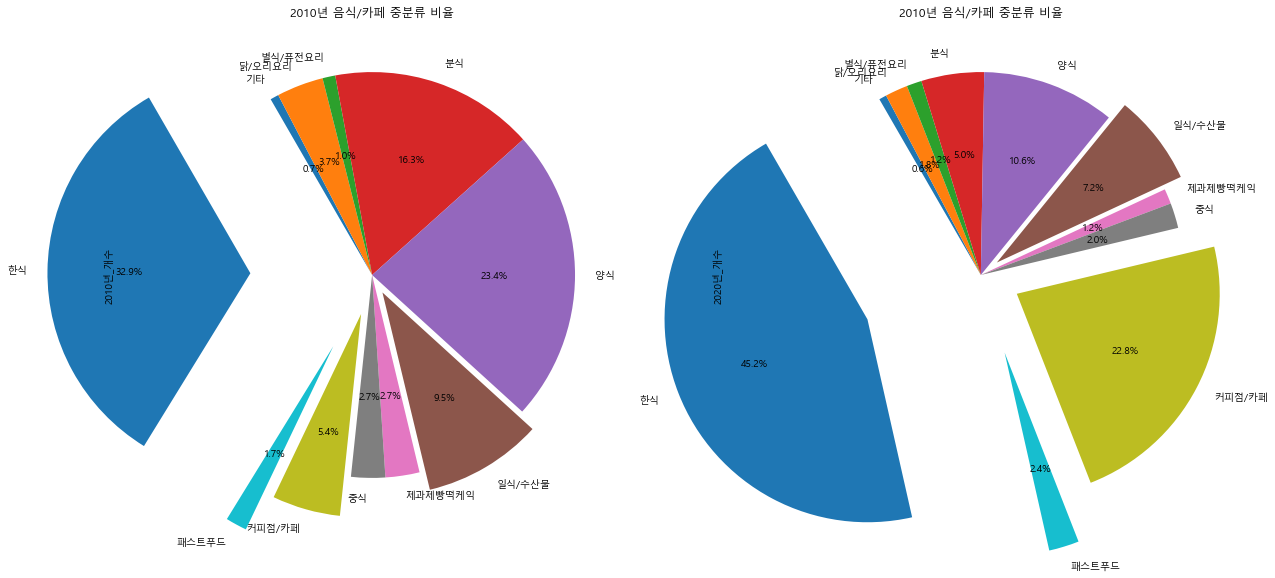

In [36]:
fig, ax = plt.subplots(1,2, figsize = (20,10))
explode_01 = [0,0,0,0,0,0.1,0,0, 0.2, 0.4, 0.6]
explode_02 = [0,0,0,0,0,0.1,0,0, 0.2, 0.4, 0.6]

feature_01.groupby('세분화')['2010년_개수'].sum()[:-1].plot.pie(autopct='%.1f%%',  startangle=120,
                                                                              counterclock=False, explode = explode_01, ax= ax [0])
ax[0].set_title('2010년 음식/카페 중분류 비율')

feature_01.groupby('세분화')['2020년_개수'].sum()[:-1].plot.pie(autopct='%.1f%%',  startangle=120,
                                                                              counterclock=False, explode = explode_02, ax= ax[1])
ax[1].set_title('2010년 음식/카페 중분류 비율')
plt.show()

### 3. 2020년 / 10년 생존한 상권 추출 
- 가정: 주소가 같고 상호명이 유사할 경우 동일 상권으로 판단 

#### 3-1 2020년 주소에 대하여 지역의 위도 / 경도 문제 확인 
- 2010년도와 2020년도 각각의 도로명 및 신주소 비교
- 아래 자료에서는 도로명 주소의 경도와 위도, 신주소의 X,Y(경도와 위도) 같은 걸로 나와있지만 이미 사후 처리한 결과
- 신주소에 맞춰서 변화(2010년 주소 경도/위도를)

In [37]:
data_2010['표준신주소'].head(2)
data_2020['도로명주소'].head(2)

# 신주소를 정의한 2020년 상권/2010년 상권
data_2010_newaddress = list(data_2010['표준신주소'])
data_2020_newaddress = list(data_2020['도로명주소'])

# 구주소로 정의한 2020년 상권/2010년 상권
data_2010_oldaddress = list(data_2010['표준구주소'])
data_2020_oldaddress = list(data_2020['지번주소'])

In [38]:
# 교집합(주소)
newaddress_inter = set(data_2010_newaddress).intersection(set(data_2020_newaddress))

# 2020년만 존재하는 주소
newaddress_only2020 = set(data_2020_newaddress) - set(data_2010_newaddress)

# 2010년만 존재하는 주소 
newaddress_only2010 = set(data_2010_newaddress) - set(data_2020_newaddress)

## 2020년/10년에 같이 등장하는 주소에 대한 경도/위도 문제 확인: 차이 발생
data_2020_find = data_2020.query('도로명주소 in @newaddress_inter')[['도로명주소','경도','위도']].drop_duplicates('도로명주소')
data_2010_find = data_2010.query('표준신주소 in @newaddress_inter')[['표준신주소','X','Y']].drop_duplicates('표준신주소').rename(columns = {'표준신주소': '도로명주소'})


## 아래코드가 위도, 경도 문제 발생 확인용(사후처리 후 확인을 진행하였기에 동일한 것으로 나옴)
result_find = pd.merge(data_2020_find, data_2010_find, on ='도로명주소')
result_find.head(5)

,도로명주소,경도,위도,X,Y
0,서울특별시 마포구 독막로7길 47,126.919630,37.549912,126.919630,37.549912
1,서울특별시 마포구 와우산로15길 40,126.921160,37.548998,126.921160,37.548998
2,서울특별시 마포구 양화로6길 45,126.916792,37.548949,126.916792,37.548949
3,서울특별시 마포구 독막로9길 8,126.919727,37.548679,126.919727,37.548679
4,서울특별시 마포구 독막로9길 26,126.920227,37.549350,126.920227,37.549350


In [39]:
##### 동일한 주소에 대한 경도/위도 정정코드 
for i in range(data_2010.shape[0]):
    for j in range(data_2020.shape[0]):
        if data_2010['표준신주소'][i] == data_2020['도로명주소'][j]:
            data_2010['X'][i] = data_2020['경도'][j]
            data_2010['Y'][i] = data_2020['위도'][j]

<ipython-input-39-589c1b2758b5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2010['X'][i] = data_2020['경도'][j]
<ipython-input-39-589c1b2758b5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2010['Y'][i] = data_2020['위도'][j]


In [40]:
# 교집합(주소)
newaddress_inter = set(data_2010_newaddress).intersection(set(data_2020_newaddress))

# 2020년만 존재하는 주소
newaddress_only2020 = set(data_2020_newaddress) - set(data_2010_newaddress)

# 2010년만 존재하는 주소 
newaddress_only2010 = set(data_2010_newaddress) - set(data_2020_newaddress)

## 2020년/10년에 같이 등장하는 주소에 대한 경도/위도 문제 확인: 차이 발생
data_2020_find = data_2020.query('도로명주소 in @newaddress_inter')[['도로명주소','경도','위도']].drop_duplicates('도로명주소')
data_2010_find = data_2010.query('표준신주소 in @newaddress_inter')[['표준신주소','X','Y']].drop_duplicates('표준신주소').rename(columns = {'표준신주소': '도로명주소'})

result_find = pd.merge(data_2020_find, data_2010_find, on ='도로명주소')
result_find.head(5)

,도로명주소,경도,위도,X,Y
0,서울특별시 마포구 독막로7길 47,126.919630,37.549912,126.919630,37.549912
1,서울특별시 마포구 와우산로15길 40,126.921160,37.548998,126.921160,37.548998
2,서울특별시 마포구 양화로6길 45,126.916792,37.548949,126.916792,37.548949
3,서울특별시 마포구 독막로9길 8,126.919727,37.548679,126.919727,37.548679
4,서울특별시 마포구 독막로9길 26,126.920227,37.549350,126.920227,37.549350


In [11]:
#### 데이터 저장하기(위도, 경도 결과 수정한 중간 CSV)
#data_2010.to_csv('F&B2010(change_xy).csv')
#data_2020.to_csv('F&B2020(change_xy).csv')

#### 3-2 데이터 확인(아래와 같이 분류)
1) 2020년 생존한 데이터  
2) 2010년에 존재하지만 20년에는 없는 데이터  
3) 2020년에 등장한 데이터  

#### (1) 상호명이 동일한(10년 생존) 데이터: 10건
1) 그 중에서 상호명은 동일하지만 업종 변경(3건) >> 확인 필요[상호명: 에이데이 / 하루  / 피오니]  
2) 그 중에서 상호명은 동일하지만 주소 변경(3건) >> 확인 필요 (심층 분석)  
3) 추가적으로 확인 정보: [용다방 / snob / 남산찌개]

In [68]:
# 2010년 상권 중 상호명이 유사하지만 약간의 변경이 있을 것으로 추정된 (실제 확인 했을 때 동일 상호)
data_2010['STORE_NM'] = data_2010['STORE_NM'].agg(lambda x: '용다방' if x =='용다방(카페김지용)' else 'snob'
                                                  if x == '스노브' else '남산찌개' if x =='남산김치찌개' 
                                                  else '마포소문난족발순대국' if x=='마포소문난족발' else x)

In [69]:
# 2010 / 2020년 상권 이름 
store_2010_nm = list(data_2010.STORE_NM)
store_2020_nm = list(data_2020.상호명)

# 상호명이 같은 상권 추출: 10개 
common_store_nm = list(set(store_2010_nm).intersection(set(store_2020_nm)))
print(common_store_nm)

# 해당 상권의 주소 변경은 없었는지(동일한 위치에서 10 내로 있는지 확인) : 상호명이 똑같은 데이터에 대한 분석
data_common_2020 = data_2020.query('상호명 in @ common_store_nm')[['상호명','상권업종_3','도로명주소']]
data_common_2010 = data_2010.query('STORE_NM in @ common_store_nm')[['STORE_NM','UPJONG3_NM','표준신주소']].rename(columns = {'STORE_NM' : '상호명'})
data_common = pd.merge(data_common_2010, data_common_2020, on ='상호명')
display(data_common)

['호밀호두', '솔내한옥집', '하바나', '비닐', '그라찌에', '피오니', '에이데이', '용다방', '남산찌개', '마포소문난족발순대국', 'snob', '하루', '다북어국', '도적']


,상호명,UPJONG3_NM,표준신주소,상권업종_3,도로명주소
0,남산찌개,부대찌개/섞어찌개,서울특별시 마포구 독막로3길 8,부대찌개/섞어찌개,서울특별시 마포구 독막로3길 8
1,snob,한식/백반/한정식,서울특별시 마포구 와우산로 59,한식/백반/한정식,서울특별시 마포구 와우산로 59
2,그라찌에,다방/커피숍/카페,서울특별시 마포구 잔다리로3길 23,커피전문점/카페/다방,서울특별시 마포구 어울마당로5길 36
3,피오니,다방/커피숍/카페,서울특별시 마포구 어울마당로 53,제과점,서울특별시 마포구 어울마당로 56
4,호밀호두,제과점,서울특별시 마포구 양화로 54-1,제과점,서울특별시 마포구 양화로 54-1
5,용다방,다방/커피숍/카페,서울특별시 마포구 독막로3길 51,커피전문점/카페/다방,서울특별시 마포구 독막로3길 51
6,하루,정통양식/경양식,서울특별시 마포구 잔다리로 9,한식/백반/한정식,서울특별시 마포구 독막로 19
7,솔내한옥집,한식/백반/한정식,서울특별시 마포구 독막로3길 21-4,한식/백반/한정식,서울특별시 마포구 독막로3길 21-4
8,도적,한식/백반/한정식,서울특별시 마포구 어울마당로5길 3,한식/백반/한정식,서울특별시 마포구 어울마당로5길 3
9,비닐,정통양식/경양식,서울특별시 마포구 와우산로 61-1,정통양식/경양식,서울특별시 마포구 와우산로 61-1


In [70]:
survive_100 = ['호밀호두','솔내한옥집', '도적', '다북어국','용다방','snob','남산찌개','피오니','마포소문난족발순대국']
survive_Inspection = ['피오니']

##### (2) 새롭게 등장한 상권

500개 中  

[1] 새롭게 등장한 상권 中 기존에 진출하지 않았던 곳에 등장한 상가(해당 상가에 2010년도에 없는 경우): 280군데  
[2] 새롭게 등장한 상권 中 2010년도에 존재했던 곳에 등장한 상가(해당 상가에 2010년에 있지만 상호명 다른 경우): 211군데

In [71]:
# 교집합(주소)
newaddress_inter = list(newaddress_inter)

# 2020년만 존재하는 주소
newaddress_only2020 = list(newaddress_only2020)

# 2010년만 존재하는 주소 
newaddress_only2010 = list(newaddress_only2010)

##### 새로운 주소에 등장한 상권 

In [72]:
# (기준: 도로명 주소) 새로운 주소에 등장한 상권 상호명
data_newstreet_2020 = data_2020.query('도로명주소 in @ newaddress_only2020')[['상호명','상권업종_2','도로명주소']]
data_newstreet_2020 = data_newstreet_2020.query('상호명 not in @ survive_100')
display(data_newstreet_2020.head())

newstreet_2020 = list(data_newstreet_2020['상호명'])
data_newstreet_2020.shape

,상호명,상권업종_2,도로명주소
0,L.A.D,한식,서울특별시 마포구 잔다리로3안길 23
1,춘삼,한식,서울특별시 마포구 와우산로15길 16
2,합정공감,한식,서울특별시 마포구 양화로6길 49
4,리버웨이,한식,서울특별시 마포구 양화로6길 92
5,칠칠켄터키,양식,서울특별시 마포구 독막로15길 5


(280, 3)

##### 기존 주소에 등장한 상권 

In [73]:
data_existingstreet_2020 = data_2020.query('도로명주소 in @ newaddress_inter')[['상호명','상권업종_2','도로명주소']]
data_existingstreet_2020 = data_existingstreet_2020.query('상호명 not in @survive_100')
display(data_existingstreet_2020.head())

existingStreet_2020 = list(data_existingstreet_2020['상호명'])
data_existingstreet_2020.shape

,상호명,상권업종_2,도로명주소
3,버건디,한식,서울특별시 마포구 독막로7길 47
6,비스트로사랑방,양식,서울특별시 마포구 와우산로15길 40
7,푸리프,한식,서울특별시 마포구 양화로6길 45
8,카페벨로주,커피점/카페,서울특별시 마포구 독막로9길 8
9,야키토리야,한식,서울특별시 마포구 독막로9길 26


(211, 3)

##### 데이터 전처리 후 저장 
- 2020년 상권에서 3가지 경우를 데이터로 지정하여 저장
  
[1] 앞서서 2010년과 2020년 상권명이 같은 경우 => 생존  
[2] 2010년에 존재한 상권에 다른 업종이 들어온 경우 => 기존 상권에 입점    
[3] 2010년에 존재하지 않는 상권에 들어온 경우 => 새로운 상권에 입점

In [74]:
data_2020['생존'] = data_2020['상호명'].agg(lambda x: '기존 상권에 입점(new)' if x in existingStreet_2020 else '새로운 상권에 입점(new)' 
                                       if x in newstreet_2020 else '생존' if x in survive_100 else '생존' 
                                       if x in survive_Inspection else '')

In [75]:
# 데이터 저장
data_2020.to_csv('F&B2020(final).csv',index = False)

In [80]:
# 생존한 업종 내용 확인
data_2020[data_2020['생존'] == '생존']

,상가업소번,상호명,지점명,상권업종대,상권업종_1,상권업종중,상권업종_2,상권업종소,상권업종_3,표준산업분,...,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도,생존
129,12114635,피오니,NaN,Q,음식,Q08,제과제빵떡케익,Q08A01,제과점,I56191,...,NaN,서울특별시 마포구 어울마당로 56,121895,4049,NaN,1,NaN,126.921248,37.549945,생존
217,20017061,호밀호두,NaN,Q,음식,Q08,제과제빵떡케익,Q08A01,제과점,I56191,...,NaN,서울특별시 마포구 양화로 54-1,121893,4045,NaN,1,NaN,126.914812,37.549679,생존
250,20001328,용다방,NaN,Q,음식,Q12,커피점/카페,Q12A01,커피전문점/카페/다방,I56220,...,서주빌딩,서울특별시 마포구 독막로3길 51,121840,4044,NaN,1,NaN,126.917744,37.550462,생존
251,20014490,마포소문난족발순대국,NaN,Q,음식,Q01,한식,Q01A08,족발/보쌈전문,I56111,...,NaN,서울특별시 마포구 양화로6길 9,121893,4044,NaN,1,NaN,126.914998,37.549356,생존
265,19998681,솔내한옥집,NaN,Q,음식,Q01,한식,Q01A01,한식/백반/한정식,I56111,...,NaN,서울특별시 마포구 독막로3길 21-4,121840,4044,NaN,1,NaN,126.916864,37.549454,생존
358,20015161,도적,홍대본점,Q,음식,Q01,한식,Q01A01,한식/백반/한정식,I56111,...,NaN,서울특별시 마포구 어울마당로5길 3,121895,4048,NaN,1,NaN,126.920156,37.548791,생존
375,16971742,snob,NaN,Q,음식,Q01,한식,Q01A01,한식/백반/한정식,I56111,...,NaN,서울특별시 마포구 와우산로 59,121828,4049,NaN,NaN,NaN,126.922858,37.549743,생존
395,20015769,남산찌개,NaN,Q,음식,Q01,한식,Q01A07,부대찌개/섞어찌개,I56111,...,NaN,서울특별시 마포구 독막로3길 8,121883,4047,NaN,1,NaN,126.916648,37.548722,생존
436,20660706,다북어국,NaN,Q,음식,Q01,한식,Q01A01,한식/백반/한정식,I56111,...,서교동복합주택,서울특별시 마포구 양화로6길 9-6,121893,4044,NaN,1,NaN,126.915166,37.549520,생존


##### (3) 참고사항: 2010년도 기준  상권 확인

259개 中

[1] 2010년도에만 유사 업종이 있었던 상권: 99군데

[2] 2020년도에서도 유사 업종은 있지만 생존 상권은 아닌 곳 : 188군데

In [79]:
# 2010년에만 상권이 존재했던 곳들
data_onlystreet_2010 = data_2010.query('표준신주소 in @ newaddress_only2010')
data_onlystreet_2010 = data_onlystreet_2010.query('STORE_NM not in @survive_100')
display(data_onlystreet_2010.head(2))

onlystreet_2010 = list(data_onlystreet_2010['STORE_NM'])
data_onlystreet_2010.shape

,UPJONG1_NM,UPJONG2_NM,UPJONG3_NM,STORE_NM,ADDRESS,PHONE,입력주소,X,Y,CLSS,PNU,주소구분,표준신주소,표준구주소,우편번호
2,음식,양식,정통양식/경양식,스테파노스키친,서울특별시 마포구 서교동 400-20 3층.4층,NaN,서울특별시 마포구 서교동 400-20 3층.4층,126.918740,37.549333,정좌표,1144012000104000000,구주소,서울특별시 마포구 독막로5길 32,서울특별시 마포구 서교동 400-20,4047.0
4,음식,한식,갈비/삼겹살,하늘도시락,서울특별시 마포구 합정동 410-20 1층 우측,NaN,서울특별시 마포구 합정동 410-20 1층 우측,126.919052,37.548093,정좌표,1144012200104099968,구주소,서울특별시 마포구 독막로 53,서울특별시 마포구 합정동 410-20,4048.0


(99, 15)

In [61]:
# 상호명은 다르지만 2010년 등장한 상권
data_existingstreet_2010 = data_2010.query('표준신주소 not in @ newaddress_only2010')
data_existingstreet_2010 = data_existingstreet_2010.query('STORE_NM not in @survive_100')
display(data_existingstreet_2010.head(2))

existingstreet_2010  = list(data_existingstreet_2010['STORE_NM'])
data_existingstreet_2010 .shape

,UPJONG1_NM,UPJONG2_NM,UPJONG3_NM,STORE_NM,ADDRESS,PHONE,입력주소,X,Y,CLSS,PNU,주소구분,표준신주소,표준구주소,우편번호
0,음식,한식,한식/백반/한정식,육값하네,서울특별시 마포구 합정동 410-31 1층,NaN,서울특별시 마포구 합정동 410-31 1층,126.919667,37.548146,정좌표,1144012200104099968,구주소,서울특별시 마포구 양화로6길 100,서울특별시 마포구 합정동 410-31,4048.0
1,음식,한식,한식/백반/한정식,나물먹는곰,"서울특별시 마포구 서교동 395-199 1,2층",NaN,"서울특별시 마포구 서교동 395-199 1,2층",126.919975,37.550348,정좌표,1144012000103950208,구주소,서울특별시 마포구 독막로7길 57,서울특별시 마포구 서교동 395-199,4043.0


(188, 15)

- 앞서서 2020년도 기준으로 저장한 데이터를 이번에는 2010년 데이터를 기준으로 데이터 저장

[1] 2010년 상가 정보 중 해당 상권에 입점한 경우: 해당 상권에 입점 O(폐업)  
[2] 2010년 상가 정보 중 해당 상권에 입점하지 않는 경우: 해당 상권에 입점 X(폐업)  
[3] 2010년과 2020년 데이터 기준으로 생존한 상권: 생존 + 생존(확인필요)

=> 생존 확인의 경우, 상호명의 유사하거나(예: 스릴에서 => 스릴스릴 이런식으로 변화) 해서 직접 확인이 필요한 경우   
=> 해당 경우는 실제 해당 상권과 전화 및 현장 방문을 통해서 확인 진행

In [58]:
data_2010['생존'] = data_2010['STORE_NM'].agg(lambda x: '해당 상권에 입점 O(폐업)' if x in existingstreet_2010 else 
                                            '해당 상권에 입점 X(폐업)' if x in onlystreet_2010  else 
                                            '생존' if x in survive_100 else '생존(확인필요)' if x in survive_Inspection else '')

In [59]:
data_2010.to_csv('F&B2010(final).csv', index = False)

#### (4) 생존 상권 추가 분석 정리  

[1] 현재 상황 
- 상호명이 일치한 경우 생존 상권으로 정의 >> 위치이전/업종변경 반영 
- But 동일한 위치에서 상호명 변경한 경우를 반영하지 못함(40군데, 이 중에서 생존 상권이 존재할 수도 있음 / 한계)

[2] 추가적인 정리
- 2010년 음식점과 2020년 음식점을 비교할 때는 여러 요소가 고려 되어야 한다. 

예시)
- 영업은 계속 유지하지만 건물주와의 계약이 끝나 가게를 이전한 경우
- 상호명을 변경하여 영업을 유지한 경우
- 판매 업종 자체를 변경하고 위치는 이전하지 않은 경우 
- 다양한 경우를 반영하는 데 어려움 발생

[3] 제안 사항
- 2010년과 2020 년도의 지역과 업종이 일치한 것을 확인
- F&B_Store_201002 데이터의 STORE_NM 열과 store_2020_zoon_food의 상호명 열을 기준으로 하여 결합
- 그 후 속성 테이블을 열고 결합된 ID가 NULL 값이 아닌 값들만 select하여 총 46개의 지점을 2010&2018_same_name이라는 이름으로 별도 저장

[4] 한계점
- 여전히 동일 지역을 대상으로 하기 때문에 => 여전히 다른 가게로 이전한 경우는 반영하기 어려움

In [61]:
# 각각 공통된 도로명 주소를 가지고 있었던 상가 정보 추출
data_2020_point = data_2020.query('도로명주소 in @ newaddress_inter and 상호명 not in @common_store_nm')[['상호명',
                                                                                '상권업종_2','상권업종_3','도로명주소']]
data_2010_point = data_2010.query('표준신주소 in @ newaddress_inter and STORE_NM not in @common_store_nm')[['STORE_NM','UPJONG2_NM',
                                                                                'UPJONG3_NM','표준신주소']]
data_2010_point.columns = ['상호명_2010','상권업종_2','상권업종_3','도로명주소']

data_2010_point['상권업종_2'] = data_2010_point['상권업종_2'].agg(lambda x: "커피점/카페" if  x == "다방/커피숍/카페" else x)
data_2010_point['상권업종_3'] = data_2010_point['상권업종_3'].agg(lambda x: "커피전문점/카페/다방"  if  x == "다방/커피숍/카페" else x)

In [62]:
# 도로명 주소와 상권업종(중분류)가 일치한 데이터 확인
data = pd.merge(data_2020_point, data_2010_point, on =['도로명주소','상권업종_2','상권업종_3'])
data  = data[['도로명주소','상권업종_2','상권업종_3','상호명','상호명_2010']]
data

,도로명주소,상권업종_2,상권업종_3,상호명,상호명_2010
0,서울특별시 마포구 독막로7길 47,한식,한식/백반/한정식,버건디,작은집
1,서울특별시 마포구 독막로9길 8,커피점/카페,커피전문점/카페/다방,카페벨로주,카페하루
2,서울특별시 마포구 독막로 55,한식,갈비/삼겹살,정가네정육식당직영점,고갈비
3,서울특별시 마포구 독막로 55,한식,갈비/삼겹살,수제갈비,고갈비
4,서울특별시 마포구 양화로8길 32-17,한식,한식/백반/한정식,에고ego,프리템포
...,...,...,...,...,...
41,서울특별시 마포구 독막로9길 19,한식,한식/백반/한정식,519,다와라야
42,서울특별시 마포구 독막로 81,한식,한식/백반/한정식,앵춘,메이드인
43,서울특별시 마포구 양화로 56,한식,한식/백반/한정식,포만감,싸바
44,서울특별시 마포구 어울마당로 58-1,닭/오리요리,후라이드/양념치킨,깐부치킨,폼스치킨


In [63]:
# 상이 20개 (해당 지역을 직접 확인)
data.iloc[0:20, :]

,도로명주소,상권업종_2,상권업종_3,상호명,상호명_2010
0,서울특별시 마포구 독막로7길 47,한식,한식/백반/한정식,버건디,작은집
1,서울특별시 마포구 독막로9길 8,커피점/카페,커피전문점/카페/다방,카페벨로주,카페하루
2,서울특별시 마포구 독막로 55,한식,갈비/삼겹살,정가네정육식당직영점,고갈비
3,서울특별시 마포구 독막로 55,한식,갈비/삼겹살,수제갈비,고갈비
4,서울특별시 마포구 양화로8길 32-17,한식,한식/백반/한정식,에고ego,프리템포
5,서울특별시 마포구 양화로12길 26,한식,한식/백반/한정식,동의명가누들샵,매일아침 직접 만든 바기순대
6,서울특별시 마포구 양화로12길 26,한식,한식/백반/한정식,닭생생,매일아침 직접 만든 바기순대
7,서울특별시 마포구 양화로12길 26,한식,한식/백반/한정식,닭선생,매일아침 직접 만든 바기순대
8,서울특별시 마포구 와우산로15길 49,한식,한식/백반/한정식,우리엄마레시피,밥
9,서울특별시 마포구 와우산로15길 49,한식,한식/백반/한정식,촨치마라탕,밥


In [64]:
data.iloc[20:40, :]

,도로명주소,상권업종_2,상권업종_3,상호명,상호명_2010
20,서울특별시 마포구 독막로9길 23,양식,정통양식/경양식,CP컴퍼니,(주)제니스까페
21,서울특별시 마포구 잔다리로3길 31,커피점/카페,커피전문점/카페/다방,소피아,노피디네 콩볶는집
22,서울특별시 마포구 와우산로17길 19-8,양식,정통양식/경양식,젠하이드어웨이홍대점,(주)젠하이더웨이
23,서울특별시 마포구 양화로6길 19,중식,중국음식/중국집,홍대교동짬뽕,행운반점
24,서울특별시 마포구 양화로6길 19,중식,중국음식/중국집,타오마라탕,행운반점
25,서울특별시 마포구 독막로3길 21,한식,한식/백반/한정식,정무관의두집살림,솥
26,서울특별시 마포구 독막로 11,분식,라면김밥분식,김가네,유림분식
27,서울특별시 마포구 양화로 78,한식,한식/백반/한정식,스텔라16,서교회관
28,서울특별시 마포구 양화로 78,한식,한식/백반/한정식,스텔라16,서교식당
29,서울특별시 마포구 양화로 78,한식,한식/백반/한정식,서교민,서교회관


In [31]:
data.iloc[40:, :]

,도로명주소,상권업종_2,상권업종_3,상호명,상호명_2010
40,서울특별시 마포구 독막로3길 26,한식,한식/백반/한정식,그라울러,향기로운밥상
41,서울특별시 마포구 독막로9길 19,한식,한식/백반/한정식,519,다와라야
42,서울특별시 마포구 독막로 81,한식,한식/백반/한정식,앵춘,메이드인
43,서울특별시 마포구 양화로 56,한식,한식/백반/한정식,포만감,싸바
44,서울특별시 마포구 어울마당로 58-1,닭/오리요리,후라이드/양념치킨,깐부치킨,폼스치킨
45,서울특별시 마포구 양화로6길 100,한식,한식/백반/한정식,어른이대공원본점,육값하네


### 4. 공시지가
- 데이터 추가 분석을 위한 공시지가 데이터 전처리
- 비록 앞선 상권 2010, 2020년과 동일한 시점의 공시지가 데이터(2010,2020)는 없는 관계로   
=> 2011, 2021년 10년 주기의 데이터를 활용하여 공시지가 변화량, 절대적인 수치로 비교 진행


#### (1) 공시지가 데이터 전처리
1. 분석 지역이 되는 마포구 3개 동으로 정리
2. 두개 데이터를 merge 하기 위해 2021년의 지번 생성(본번 + 부번)

In [ ]:
# 데이터 전처리 후 저장
value = pd.read_csv('공시지가_2021년.csv', encoding = 'cp949', low_memory=False)
value = value[value['시군구명'] == "마포구"]
value.to_csv('공시지가_2020년.csv',index = False)

value = pd.read_csv('공시지가_2011년.csv', encoding = 'cp949', low_memory=False)
value = value[value['시군구명'] == "마포구"]
value.to_csv('공시지가_2011년.csv',index = False)

In [46]:
# 마포구 중에서도 분석 지역으로 데이터 전처리하기 위한 정보 추출(벙정동명)
unique_data = pd.read_csv('find.csv', encoding = 'cp949',low_memory=False) # 912개 
unique_data = unique_data.rename(columns = {'추출_시도': '시도명',  '추출_시군': '시군구명', '추출_법정': '법정동명'})

unique_data['확인'] = unique_data['고유번호'].agg(lambda x: str(x)[10:])
unique_value = list(unique_data['확인'])

dong = ['서교동', '합정동', '상수동']

In [47]:
unique_data.시구동.unique()

array(['서울특별시 마포구 서교동', '서울특별시 마포구 상수동', '서울특별시 마포구 합정동'], dtype=object)

##### 2021년 전처리

In [48]:
# 2021년 진행 이후, 지번 전처리
price_2021 = pd.read_csv('공시지가_2021년.csv',  encoding = 'cp949',low_memory=False)
price_2021['확인'] = price_2021['토지코드'].agg(lambda x: str(x)[10:]) 

# 마포구 / 동 자르기 
first_data = price_2021.query('시군구명 == "마포구" and 법정동명 in @ dong')
first_data['본번'] = first_data['본번'].agg(lambda x: x.astype('int'))
first_data['부번'] = first_data['부번'].agg(lambda x: x.astype('int'))

# 지번 만들기(본번 부번)
jiben_list = []
for index in range(first_data.shape[0]):
    bon = first_data.iloc[index,9]
    ben = first_data.iloc[index,10]
    jiben = str(bon) + '-' + str(ben)
    jiben_list.append(jiben)
    
first_data['지번'] = jiben_list 

data_01 = first_data[['시도명','시군구명','법정동명','토지코드','공시지가(원/㎡)','지번','확인','기준년도']]
data_01 = data_01.rename(columns = {'공시지가(원/㎡)': '202101_공시지가',  '확인': '2021확인'})

<ipython-input-48-c8e7aa52ba45>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_data['본번'] = first_data['본번'].agg(lambda x: x.astype('int'))
<ipython-input-48-c8e7aa52ba45>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_data['부번'] = first_data['부번'].agg(lambda x: x.astype('int'))
<ipython-input-48-c8e7aa52ba45>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

##### 2011년 데이터 동일하게 전처리

In [50]:
# 2011년 데이터 동일하게 전처리
price_2011 = pd.read_csv('공시지가_2011년.csv', encoding = 'cp949', low_memory=False)
price_2011['확인'] = price_2011['토지코드'].agg(lambda x: str(x)[10:]) 

# 마포구 / 동 자르기 
sec_data = price_2011.query('시군구명 == "마포구" and 법정동명 in @ dong')
sec_data = sec_data.query('확인 in @ unique_value')

data_02 = sec_data[['시도명','시군구명','법정동명','토지코드','공시지가(원/㎡)','기준년월','확인']]
data_02 = data_02.rename(columns = {'공시지가(원/㎡)': '201101_공시지가',  '확인': '2011확인'})

##### 두개의 데이터 합쳐서 데이터 활용

In [52]:
data = pd.merge(data_01, data_02, on = ['시도명','시군구명','법정동명','토지코드'])
data = data[['시도명','시군구명','법정동명','토지코드','201101_공시지가', '202101_공시지가','지번']]

In [53]:
data

,시도명,시군구명,법정동명,토지코드,201101_공시지가,202101_공시지가,지번
0,서울특별시,마포구,상수동,1144011500100850006,864000,3976000,85-6
1,서울특별시,마포구,상수동,1144011500100850009,2750000,12410000,85-9
2,서울특별시,마포구,상수동,1144011500100850010,2670000,12050000,85-10
3,서울특별시,마포구,상수동,1144011500100860007,4390000,14780000,86-7
4,서울특별시,마포구,상수동,1144011500100860053,4580000,15400000,86-53
...,...,...,...,...,...,...,...
990,서울특별시,마포구,합정동,1144012200104230003,1880000,4471000,423-3
991,서울특별시,마포구,합정동,1144012200104230004,1760000,2531000,423-4
992,서울특별시,마포구,합정동,1144012200104230005,1760000,2531000,423-5
993,서울특별시,마포구,합정동,1144012200104240000,1140000,2531000,424-0


#### (1) 공시지가 단게 분포 정의 
- point_01: 2010년 기준으로 입점되고 폐업된 상권
- point_02: 2010년 기준으로 입점안되고 폐업된 상권

In [86]:
# 해당 지역에 대한 data 오류로 인해서 입력 진행
point_01 = pd.read_csv('point_01.csv', encoding = 'cp949', low_memory=False)
point_01 = point_01.sort_values(by = 'existing_개별공시지')
point_01.iloc[-6:,-1] = [14250000, 19100000, 12610000, 15770000, 12610000,14800000]

In [124]:
# 공시지가의 단계 표현하기 위한 함수
def time(x):
    value = ''
    if x == '-1':
        value = '미상'
    elif x <=5000000:
        value = '1단계'
    elif x <=10000000:
        value = '2단계'
        
    elif x <=15000000:
        value = '3단계'
    elif x <=20000000:
        value = '1단계'
    else:
        value = '5단계'  
    return value

#### (2) 해석 
- 3단계 공시지가가 대부분 많음, 4단계 공시지가의 경우는 없음 
- 2020년에 입점이 안되고, 되는 것에서 개별 공시가로 단편적 비율로 확인하기 어려움

=> QGIS를 활용해 전반적인 분포, 공시지가 변화량으로 판단하고자 함

In [127]:
point_01['existing_개별공시지'].agg(lambda x: time(x)).value_counts() / point_01['existing_개별공시지'].agg(lambda x: time(x)).value_counts().sum()

3단계    0.736559
1단계    0.161290
5단계    0.075269
2단계    0.026882
Name: existing_개별공시지, dtype: float64

In [125]:
point_02 = pd.read_csv('point_02.csv', encoding = 'cp949', low_memory=False)
point_02 = point_02.sort_values(by = '개별공시지')
point_02['개별공시지'].agg(lambda x: time(x)).value_counts()

3단계    66
1단계    17
5단계     7
2단계     6
Name: 개별공시지, dtype: int64

In [126]:
point_02['개별공시지'].agg(lambda x: time(x)).value_counts() / point_02['개별공시지'].agg(lambda x: time(x)).value_counts().sum()

3단계    0.687500
1단계    0.177083
5단계    0.072917
2단계    0.062500
Name: 개별공시지, dtype: float64

#### 5. 매출 데이터 활용
- 나이대 매출액의 합: 개인 매출금액과 같음
- 총 5가지 => 시간대, 주중/주말, 요일별, 음식점별로 매출 데이터 활용ㅇ

In [191]:
sale_data = pd.read_csv('마포_신용카드데이터.csv', encoding = 'cp949', low_memory = False) # id: BAS_MGT_SN

# 나이대 
age_10 = [i for i in list(sale_data.columns) if '10s' in i]
age_20 = [i for i in list(sale_data.columns) if '20s' in i]
age_30 = [i for i in list(sale_data.columns) if '30s' in i]
age_40 = [i for i in list(sale_data.columns) if '40s' in i]
age_50 = [i for i in list(sale_data.columns) if '50s' in i]
age_60 = [i for i in list(sale_data.columns) if '60s' in i]

# 시간대
time = [i for i in list(sale_data.columns) if 'T_hr' in i]

# 주중/주말
week = [i for i in list(sale_data.columns) if 'T_wk' in i]

# 요일
day = [i for i in list(sale_data.columns) if 'T_week' in i]

# 음식점 
food = ['T_gogi','T_bunsik','T_byul','T_west', 'T_jap','T_bread','T_china','T_chicken','T_coffee','T_fastfood','T_korean','T_seafood']

food_2 = ['T_korean','T_coffee']

In [192]:
# 나이에 대한 feature
sale_data['10대_매출액'] = sale_data.loc[:, age_10].sum(axis =1)
sale_data['20대_매출액'] = sale_data.loc[:, age_20].sum(axis =1)
sale_data['30대_매출액'] = sale_data.loc[:, age_30].sum(axis =1)
sale_data['40대_매출액'] = sale_data.loc[:, age_40].sum(axis =1)
sale_data['50대_매출액'] = sale_data.loc[:, age_50].sum(axis =1)
sale_data['60대이상_매출액'] = sale_data.loc[:, age_60].sum(axis =1)

# 음식점/카페 매출
sale_data['음식점/카페_매출액'] = sale_data.loc[:, food].sum(axis =1)
sale_data['only_한식+카페_매출액'] = sale_data.loc[:, food_2].sum(axis =1)

In [193]:
#  1년 - 2달
display((sale_data.iloc[:,17] - sale_data.iloc[:,18]).head(3))

# 여성 + 남성
display(sale_data.iloc[:,19:21].sum(axis = 1).head(3))

# 개인 + 법인
display(sale_data.iloc[:,21:23].sum(axis = 1).head(3))

0     22707600.0
1    160930400.0
2     65479900.0
dtype: float64

0     12781400.0
1    103184000.0
2     39159500.0
dtype: float64

0     26464700.0
1    172472000.0
2     72125400.0
dtype: float64

In [194]:
sale_data.iloc[:,16:23]

,T_opn_cls,T_amt_1y,T_amt_2m,T_male,T_female,T_indvsl,T_corpo
0,5,2.860580e+07,5898200.0,7080300.0,5701100.0,1.278140e+07,13683300.0
1,9,1.931984e+08,32268000.0,69247000.0,33937000.0,1.031840e+08,69288000.0
2,7,7.772390e+07,12244000.0,24235200.0,14924300.0,3.915950e+07,32965900.0
3,64,2.542189e+09,463420090.0,915943108.0,602625397.0,1.518569e+09,813224948.0
4,2,1.421761e+08,10599750.0,41380520.0,20844440.0,6.222496e+07,56379800.0
...,...,...,...,...,...,...,...
310,14,1.786959e+08,40478010.0,73690225.0,33297320.0,1.069875e+08,54739100.0
311,23,8.489844e+08,143130120.0,344524825.0,269510861.0,6.140357e+08,147513260.0
312,4,1.677043e+08,36245600.0,54456700.0,66897600.0,1.213543e+08,36237800.0
313,2,9.570000e+05,460000.0,344000.0,33000.0,3.770000e+05,520000.0


In [196]:
new = sale_data[['BAS_MGT_SN','10대_매출액','20대_매출액','30대_매출액','40대_매출액','50대_매출액','60대이상_매출액',
           '음식점/카페_매출액','only_한식+카페_매출액']]

In [198]:
new.to_csv('sale_plus_feature.csv',index = False)